In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
import tmv_app.models as tm
import scoping.models as sm
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [ ]:
speech_search_id = 63
s = pm.Search.objects.get(id=63) # speeches
print(pm.Utterance.objects.filter(search_matches=s).count())

pars_search_id = 69
#s = pm.Search.objects.get(id=pars_search_id) # paragraphs
#print(pm.Paragraph.objects.filter(search_matches=s).count())

In [8]:
s = None

if s:
    search_object_type = s.search_object_type
    name_str = str(s.id)
else:
    search_object_type = 2
    name_str = 'all'

808344


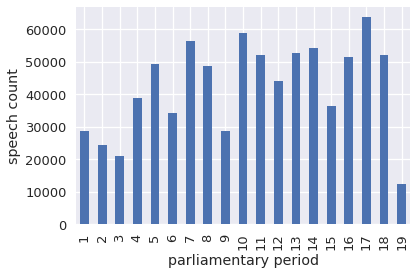

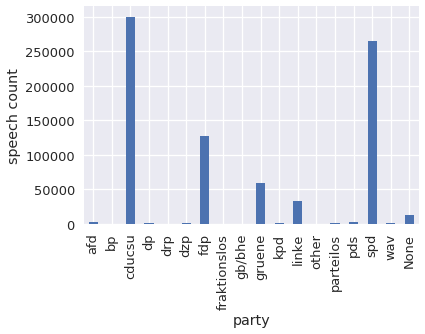

In [9]:
# show some statistics on document distribution

if search_object_type == 2:
    if s:
        uts = pm.Utterance.objects.filter(search_matches=s)
    else:
        uts = pm.Utterance.objects.all()
    print(uts.count())
    period_link = 'document__parlperiod__n'
    party_link = 'speaker__party__name'
    period_counts = uts.values('document__parlperiod__n').annotate(count=Count('id')).order_by()
    party_counts = uts.values('speaker__party__name').annotate(count=Count('id')).order_by()
    ylabel = 'speech count'
else:
    if s:
        pars = pm.Paragraph.objects.filter(search_matches=s)
    else:
        pars = pm.Paragraph.objects.all()
    print(pars.count())
    period_link = 'utterance__document__parlperiod__n'
    party_link = 'utterance__speaker__party__name'
    period_counts = pars.values('utterance__document__parlperiod__n').annotate(count=Count('id')).order_by()
    party_counts = pars.values('utterance__speaker__party__name').annotate(count=Count('id')).order_by()
    ylabel = 'paragraph count'

# plot parliamentary period counts
sns.set()
sns.set_context("talk")
df_period_counts = pd.DataFrame.from_dict(period_counts)
df_period_counts = df_period_counts.set_index(period_link)
df_period_counts.plot(kind='bar', legend=False)
plt.xlabel('parliamentary period')
plt.ylabel(ylabel)
fig = plt.gcf()
fig.savefig('./plots/topic_analysis/parlperiod_speech_count_search_{}.png'.format(name_str), dpi=300,  bbox_inches="tight")

# plot party counts
df_party_counts = pd.DataFrame.from_dict(party_counts)
df_party_counts = df_party_counts.set_index(party_link)

# drop some of the labels:
#df_party_counts = df_party_counts.drop(["fraktionslos", "parteilos", "pds", None])

df_party_counts.plot(kind='bar', legend=False)
plt.xlabel('party')
plt.ylabel(ylabel)
fig = plt.gcf()
fig.savefig('./plots/topic_analysis/party_speech_count_search_{}.png'.format(name_str), dpi=300,  bbox_inches="tight")

utterance__document__parlperiod__n
1     6.915335
2     6.908383
3     6.926201
4     7.011589
5     7.045443
6     7.054744
7     7.105724
8     7.113175
9     7.058213
10    7.078672
11    7.078159
12    7.122264
13    7.087727
14    6.988360
15    7.055910
16    7.073531
17    7.081795
18    6.971015
19    6.854043
dtype: float64

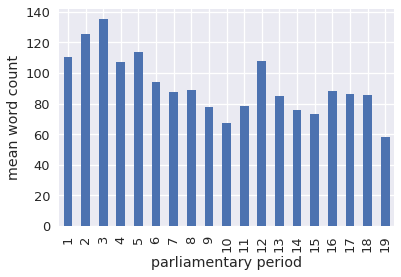

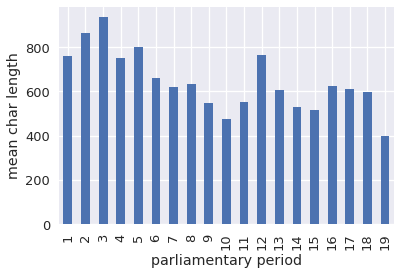

In [12]:
# statistics on length distribution for paragraphs

if s:
    pars = pm.Paragraph.objects.filter(search_matches=s)
else:
    pars = pm.Paragraph.objects.all()

# parlperiod
category_db_link = 'utterance__document__parlperiod__n'
category_name = 'parliamentary period'

# party
#category_db_link = 'utterance__speaker__party__name'
#category_name = 'party'

mean_length = pars.values(category_db_link).annotate(mean_wc=Avg('word_count'),
                                                                    mean_charlen=Avg('char_len')).order_by()

df_mean_length = pd.DataFrame.from_dict(mean_length)

df_mean_length = df_mean_length.set_index(category_db_link)
df_mean_length.plot(kind='bar', y='mean_wc', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean word count')

df_mean_length.plot(kind='bar', y='mean_charlen', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean char length')

df_mean_length['mean_charlen'] / df_mean_length['mean_wc']

document__parlperiod__n
1     6.915335
2     6.908383
3     6.926201
4     7.011589
5     7.045443
6     7.054744
7     7.105724
8     7.113175
9     7.058213
10    7.078672
11    7.078159
12    7.122264
13    7.087727
14    6.988360
15    7.055910
16    7.073531
17    7.081795
18    6.971015
19    6.854043
dtype: float64

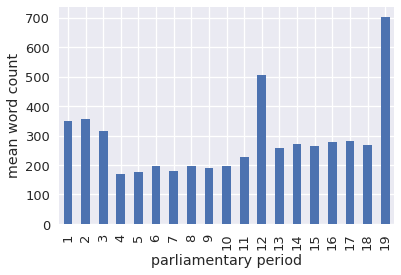

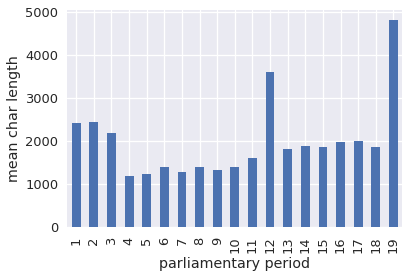

In [13]:
# statistics on length distribution for speeches

if s:
    uts = pm.Utterance.objects.filter(search_matches=s)
else:
    uts = pm.Utterance.objects.all()

# parlperiod
category_db_link = 'document__parlperiod__n'
category_name = 'parliamentary period'

# party
#category_db_link = 'speaker__party__name'
#category_name = 'party'

ut_length = uts.values(category_db_link, 'id').annotate(sum_wc=Sum('paragraph__word_count'), sum_charlen=Sum('paragraph__char_len'))

df_ut_length = pd.DataFrame.from_dict(ut_length)

df_mean_length = df_ut_length.groupby(category_db_link).mean()

df_mean_length.plot(kind='bar', y='sum_wc', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean word count')

df_mean_length.plot(kind='bar', y='sum_charlen', legend=False)
plt.xlabel(category_name)
plt.ylabel('mean char length')

df_mean_length['sum_charlen'] / df_mean_length['sum_wc']